In [51]:
from pathlib import Path
from typing import Union, Callable, Any, Optional
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision

import util
import learning
import data_helpers

from importlib import reload

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [50]:
reload(learning)
reload(data_helpers)

NameError: name 'data_helpers' is not defined

## Pet Breeds Dataset

37 cat and dog breeds, around 200 examples each. 

Dled via fastai URLs.PETS https://docs.fast.ai/data.external.html
Direct: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [2]:
breed_re = re.compile(r"(\D*)_\d*")


def extract_breed(file_name: str) -> str:
    return breed_re.match(file_name).group(1)


data_base_path = Path(r"F:/Coding/data-science/datasets/oxford-iiit-pet/images")
label_names = sorted(set([extract_breed(item) for item in os.listdir(data_base_path)]))
label_dict = {item: index for index, item in enumerate(label_names)}
print(label_dict)

{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11, 'american_bulldog': 12, 'american_pit_bull_terrier': 13, 'basset_hound': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english_cocker_spaniel': 18, 'english_setter': 19, 'german_shorthaired': 20, 'great_pyrenees': 21, 'havanese': 22, 'japanese_chin': 23, 'keeshond': 24, 'leonberger': 25, 'miniature_pinscher': 26, 'newfoundland': 27, 'pomeranian': 28, 'pug': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


In [3]:
# https://pytorch.org/vision/stable/auto_examples/plot_scripted_tensor_transforms.html#sphx-glr-auto-examples-plot-scripted-tensor-transforms-py
transforms = torch.nn.Sequential(
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
)
# transforms = torch.nn.Sequential(
#     torchvision.transforms.Resize(size=(224, 224)),
#     torchvision.transforms.TrivialAugmentWide(),
#     # torchvision.transforms.Resize(size=(460, 460)),
#     # torchvision.transforms.RandomHorizontalFlip(p=0.3),
#     # torchvision.transforms.RandomRotation(30),
#     # torchvision.transforms.CenterCrop(224)
# )
valid_transforms = torch.nn.Sequential(torchvision.transforms.Resize(size=(224, 224)))


class OxfordPetImageDataset(torch.utils.data.TensorDataset):
    """
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    image_paths: list[str]

    def __init__(
        self,
        img_dir: Path,
        transform: Union[Callable[[torch.Tensor], torch.Tensor], None] = None,
        target_transform: Union[
            Callable[[Union[torch.Tensor, Any]], torch.Tensor], None
        ] = None,
        limit_data: Optional[int] = None,
    ):
        self.img_dir = img_dir
        self.image_paths = os.listdir(img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        file_name = self.image_paths[idx]
        label = extract_breed(file_name)

        img_path = self.img_dir / file_name
        try:
            # image = torchvision.io.read_image(str(img_path), torchvision.io.ImageReadMode.RGB).float() / 255
            # RandAugment requires unit8, don't perform float transform until after transofrm
            image = torchvision.io.read_image(
                str(img_path), torchvision.io.ImageReadMode.RGB
            )
        except:
            print(file_name, label, img_path)
        if self.transform:
            image = self.transform(image).float() / 255
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


dataset = OxfordPetImageDataset(
    img_dir=data_base_path,
    # transform=torchvision.transforms.Resize(size=(224, 224)),
    transform=transforms,
    target_transform=torchvision.transforms.Lambda(
        lambda y: data_loaders.label_name_one_hot(y, label_dict)
    ),
    # limit_data=1000
)
train_dataset, valid_dataset = data_loaders.split_datasets(
    dataset, validation_percent=0.1, validation_transforms=valid_transforms
)
# test_dataset = OxfordPetImageDataset(
#     img_dir=data_base_path,
#     transform=torchvision.transforms.Resize(size=(224, 224))
# )

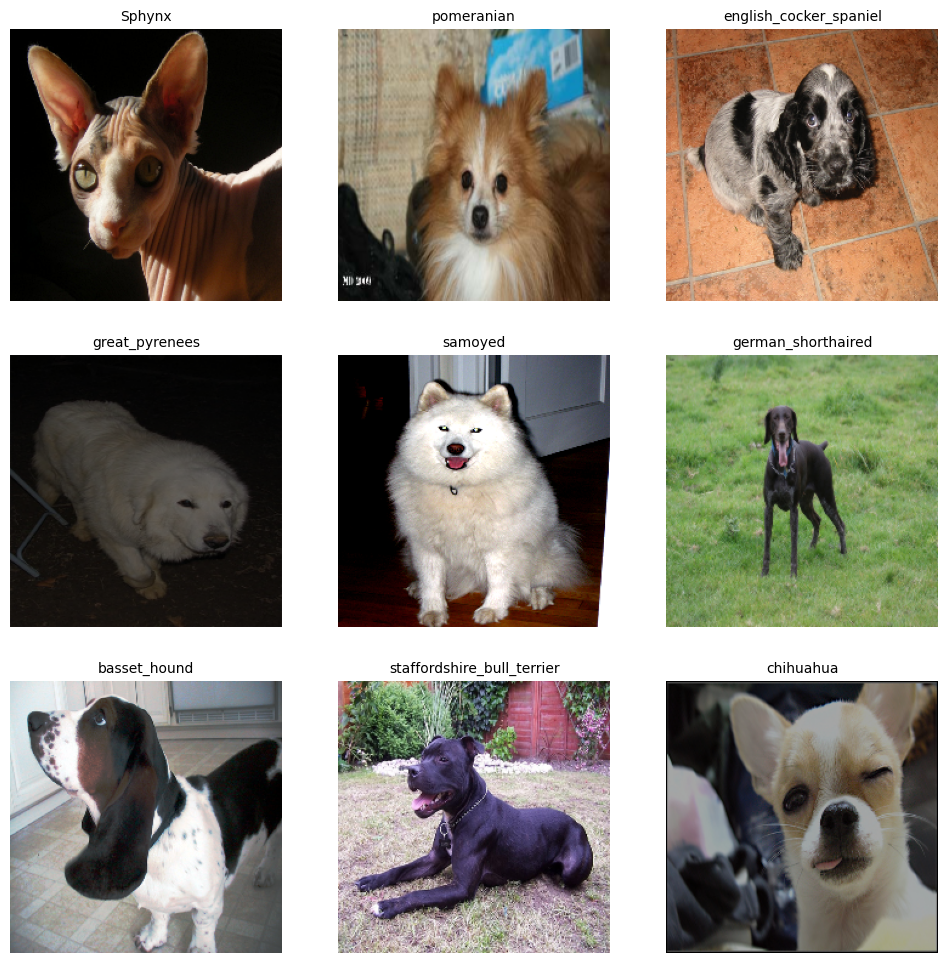

In [4]:
data_loaders.preview_data_sample(train_dataset, label_dict)

In [11]:
# Unsupported images despite jpg? There were only 6, removed them
# for img in dataset.image_paths:
#     try:
#         torchvision.io.read_image(str(data_base_path/img), torchvision.io.ImageReadMode.RGB).float() / 255
#     except:
#         print(img)

Abyssinian_34.jpg
Egyptian_Mau_139.jpg
Egyptian_Mau_145.jpg
Egyptian_Mau_167.jpg
Egyptian_Mau_177.jpg
Egyptian_Mau_191.jpg


In [10]:
reload(learning)

<module 'learning' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\learning.py'>

In [56]:
model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
# Freeze all pretrained parameters to avoid using them in training
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the head (the last layer, aka the final classification layer) with our own randomized weights
# and output the appropriate number of classes for our problem.
# The last layer was trained for the particular classification problem that the original model was intended for
# It is never any good for you (unless you are doing an identical problem)
# Match the in features with those of the original last layer, then specify new ones for the out for your problem
# Note that different models may have different names for the classification layer (see "image_nets fine-tuning conversation.md")
model.fc = torch.nn.Linear(model.fc.in_features, len(label_dict.items())).to("cuda")

# optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        # 32 is most common batch size? Most recommended? Fastai used 64
        torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True),
        torch.utils.data.DataLoader(valid_dataset, batch_size=64),
    ),
    model=model,
    loss_function=torch.nn.CrossEntropyLoss(),
    metric_function=learning.accuracy,
    optimizer=optimizer,
    scheduler=None,
    device="cuda",
    # device="cpu"
    early_stop_patience=3,
    early_stop_min_delta=0.1,
    restore_min_loss_state=True,
)

# TODOs
# Best way to normalize image sizes
# See how much unfreezing prior layers helps (aka fine tuning?)

⠸ Finding learning rates... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━  87% 0:00:11 0:01:16

Early stop due to spike in min loss.

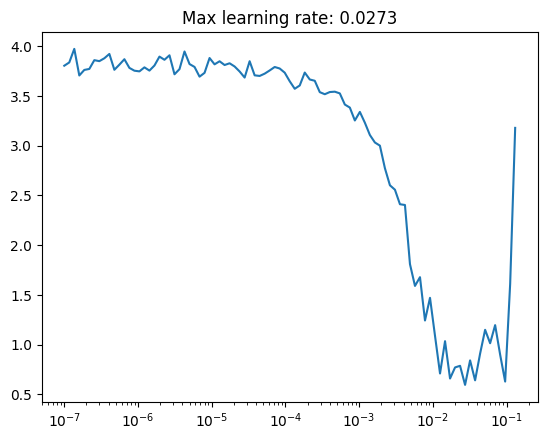

In [6]:
learner.learning_rate_find()

In [8]:
1e-2, 1e-3

(0.01, 0.001)

In [5]:
torch.cuda.empty_cache()
learner.optimizer = torch.optim.Adam(model.fc.parameters(), lr=3e-3)
# Best accuracy so far: 89.2%, 3 epochs without unfreezing, no data augments.
# TODO: Try unfreezing and training more
# TODO: Try a more complex final layer, with convnet then fc?
learner.train_model(epochs=3)

Epochs     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:04:31 3 / 3 0.0049 loss
  Validating ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:07 101.84 items/sec 0.0049 loss
                       Epochs                       
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Epoch ┃ Train Loss ┃ Valid Loss ┃ Metric ┃ Time  ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 1     │ 0.015124   │ 0.006835   │ 87.7%  │ 01:50 │
│ 2     │ 0.005134   │ 0.005410   │ 88.8%  │ 01:23 │
│ 3     │ 0.004099   │ 0.004949   │ 89.8%  │ 01:17 │
└───────┴────────────┴────────────┴────────┴───────┘

Restored min valid loss weights.


In [8]:
learner.save_model(Path("test_model.pt"))

In [57]:
learner.load_model(Path("test_model.pt"))

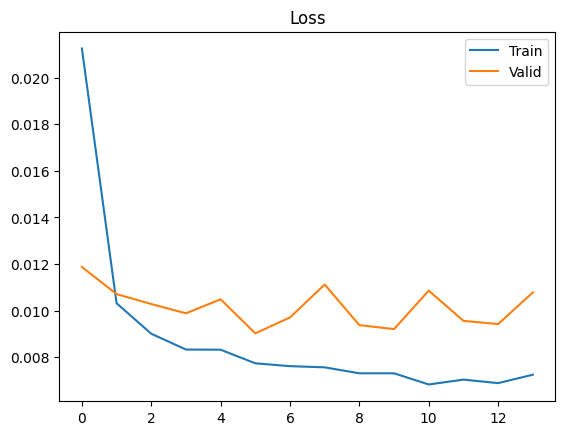

In [7]:
learner.plot_epoch_data()

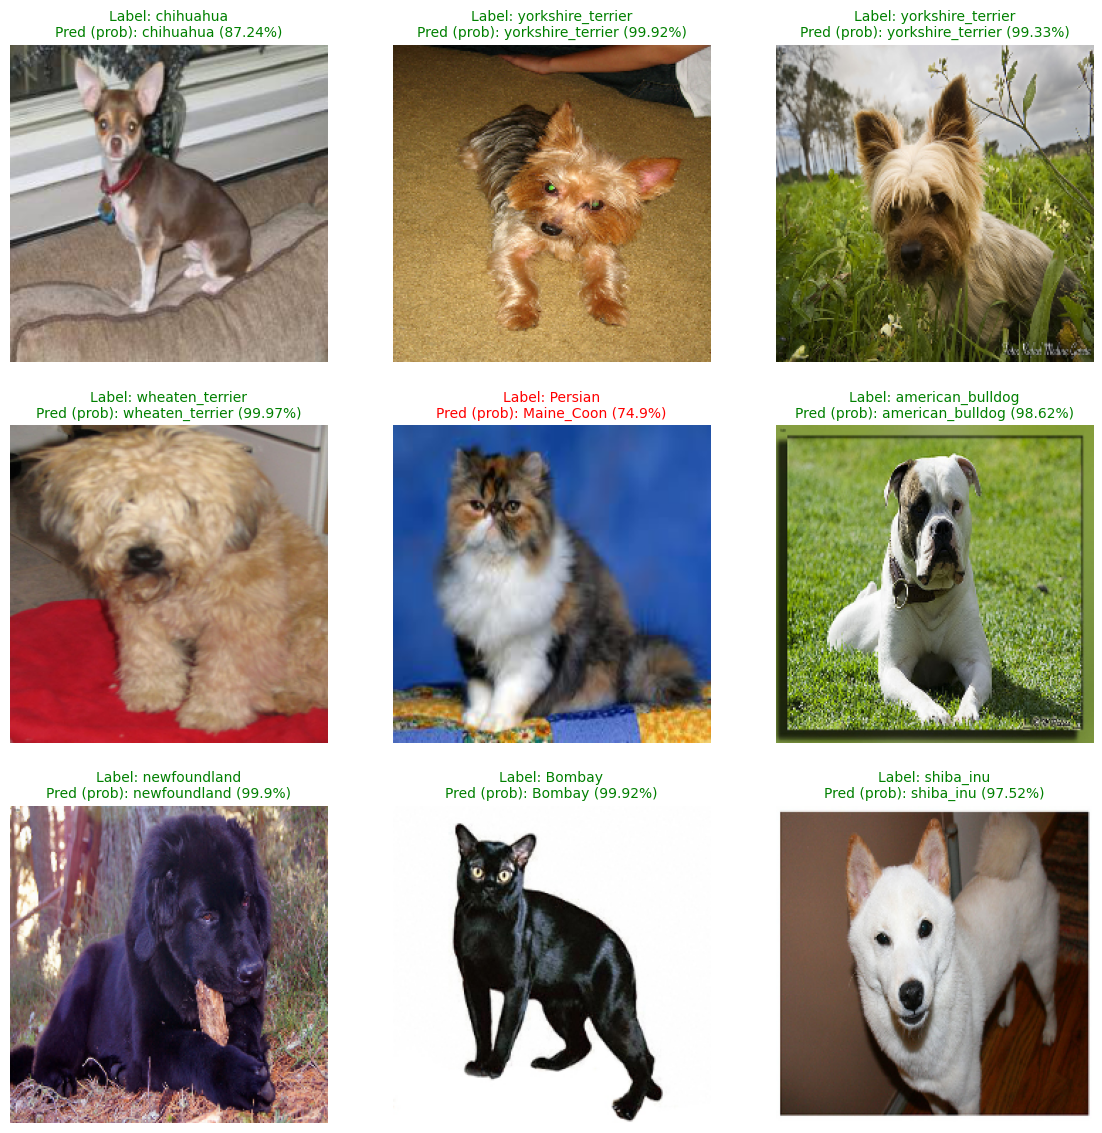

In [59]:
data_loaders.preview_tested_data_sample(
    valid_dataset, learner.model, label_dict, "cuda"
)

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [60]:
preds, labels = learner.get_preds(learner.data_loaders.valid)

⠙ Making predictions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━  92% 0:00:01 0:00:07

In [66]:
cm = confusion_matrix(labels.argmax(dim=1).tolist(), preds.argmax(dim=1).tolist())
cm

array([[17,  0,  0, ...,  0,  0,  0],
       [ 3,  9,  0, ...,  0,  0,  1],
       [ 0,  0, 24, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0, 16,  0],
       [ 0,  0,  0, ...,  0,  0, 17]], dtype=int64)

In [73]:
max_by_row = []
for row_num, row in enumerate(cm):
    row_no_identity = row.copy()
    row_no_identity[row_num] = -1
    max = row_no_identity.max()
    max_idx = row_no_identity.tolist().index(max)
    max_by_row.append((row_num, max_idx, max))

max_by_row = sorted(max_by_row, key=lambda x: x[2], reverse=True)
max_by_row

[(1, 5, 4),
 (7, 6, 4),
 (34, 13, 4),
 (14, 15, 3),
 (6, 8, 2),
 (8, 2, 2),
 (13, 15, 2),
 (16, 12, 2),
 (17, 13, 2),
 (18, 19, 2),
 (19, 12, 2),
 (26, 13, 2),
 (4, 2, 1),
 (5, 1, 1),
 (9, 4, 1),
 (11, 0, 1),
 (12, 13, 1),
 (15, 12, 1),
 (20, 19, 1),
 (21, 31, 1),
 (22, 18, 1),
 (27, 18, 1),
 (31, 21, 1),
 (33, 13, 1),
 (0, 1, 0),
 (2, 0, 0),
 (3, 0, 0),
 (10, 0, 0),
 (23, 0, 0),
 (24, 0, 0),
 (25, 0, 0),
 (28, 0, 0),
 (29, 0, 0),
 (30, 0, 0),
 (32, 0, 0),
 (35, 0, 0),
 (36, 0, 0)]

In [76]:
reload(data_helpers)

<module 'data_helpers' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\data_helpers.py'>

In [78]:
data_helpers.most_confused(preds, labels, label_names, 2)

[('Bengal', 'Egyptian_Mau', 4),
 ('Persian', 'Maine_Coon', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('basset_hound', 'beagle', 3),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Ragdoll', 'Birman', 2),
 ('american_pit_bull_terrier', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_setter', 'american_bulldog', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('British_Shorthair', 'Birman', 1),
 ('Egyptian_Mau', 'Bengal', 1),
 ('Russian_Blue', 'British_Shorthair', 1),
 ('Sphynx', 'Abyssinian', 1),
 ('american_bulldog', 'american_pit_bull_terrier', 1),
 ('beagle', 'american_bulldog', 1),
 ('german_shorthaired', 'english_setter', 1),
 ('great_pyrenees', 'samoyed', 1),
 ('havanese', 'english_cocker_spaniel', 1),
 ('newfoundland', 'english_cocker_spaniel', 1),
 ('samoyed', 'great_pyrenees', 1),
 ('shiba_inu', 'american_pit_bull_terrier', 1)]

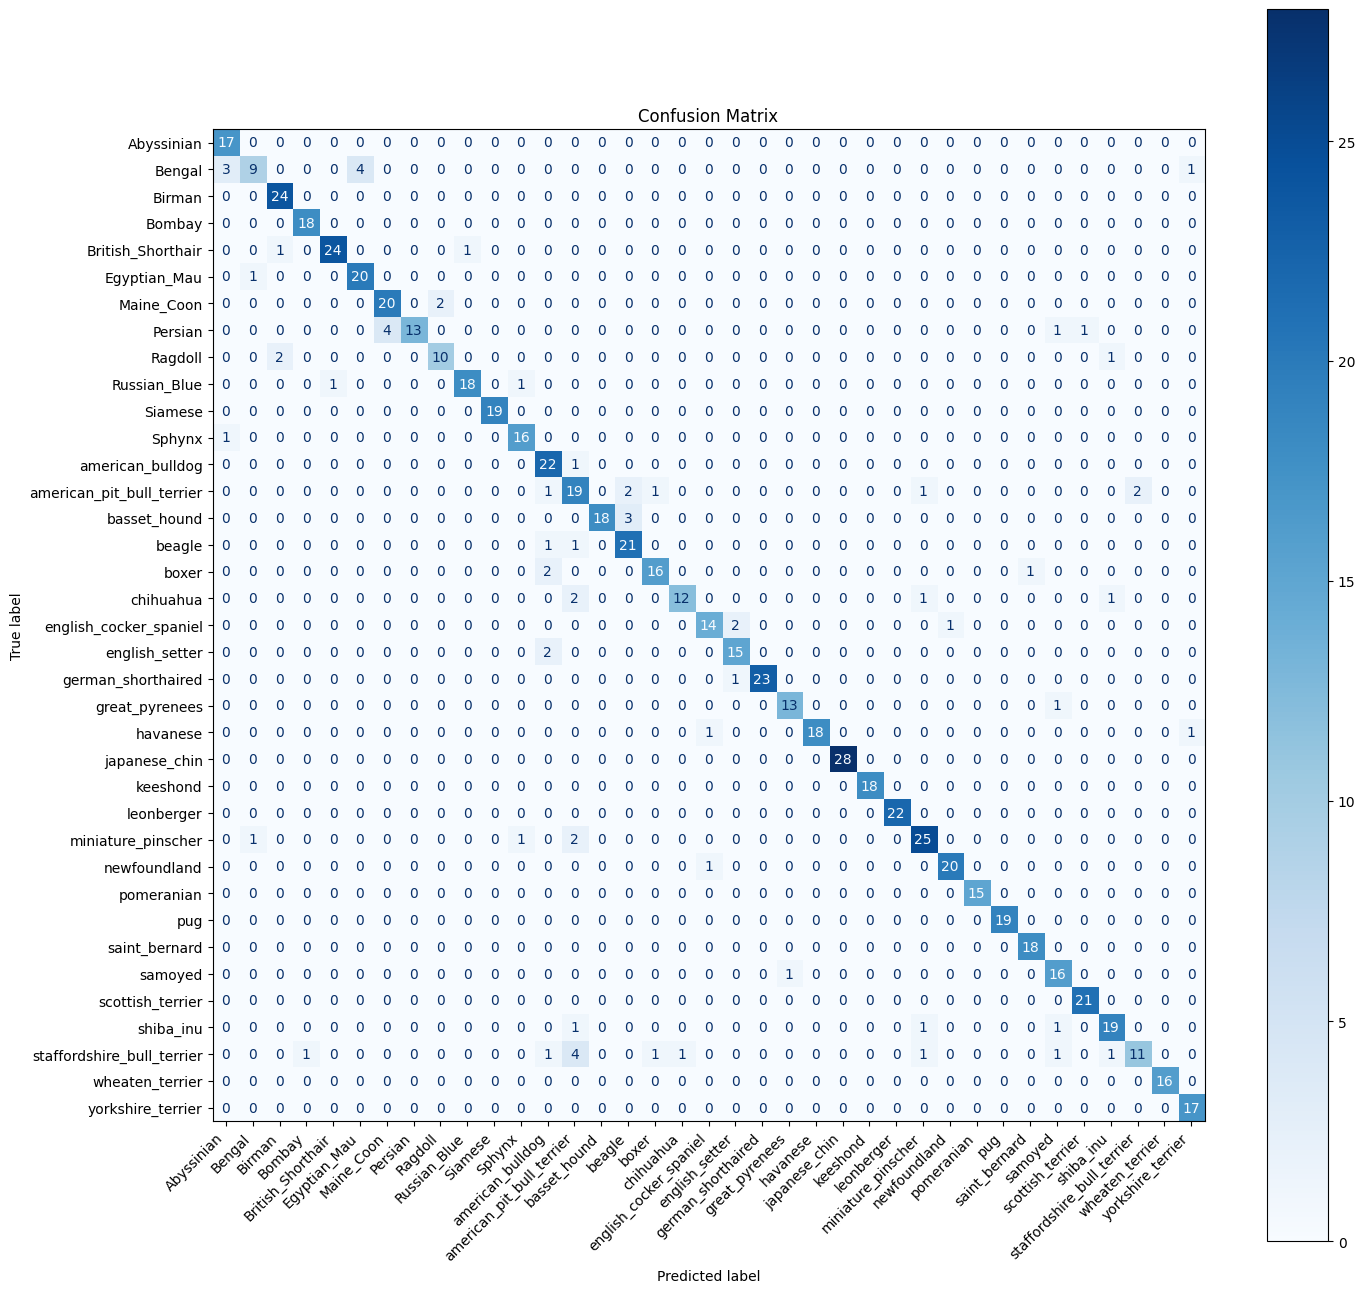

In [61]:
data_helpers.plot_confusion_matrix(preds, labels, label_names)

## Dog Breeds - 120 Classes

A much wider range of classes in this dataset.

In [3]:
data_base_path = Path(r"F:\Coding\data-science\datasets\dog-breeds")
data_labels_df = pd.read_csv(data_base_path/"labels.csv")
label_names = sorted(data_labels_df['breed'].unique())
label_dict = {item: index for index, item in enumerate(label_names)}
for key in list(label_dict.keys())[:5]: print(f"{key}: {label_dict[key]}")

affenpinscher: 0
afghan_hound: 1
african_hunting_dog: 2
airedale: 3
american_staffordshire_terrier: 4


In [ ]:
# https://pytorch.org/vision/stable/auto_examples/plot_scripted_tensor_transforms.html#sphx-glr-auto-examples-plot-scripted-tensor-transforms-py
transforms =torch.nn.Sequential(
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
)
# transforms =torch.nn.Sequential(
#     torchvision.transforms.Resize(size=(360, 360)),
#     torchvision.transforms.RandomHorizontalFlip(p=0.3),
#     torchvision.transforms.RandomRotation(25),
#     torchvision.transforms.RandomCrop(224)
# )

class DogVisionImageDataset(torch.utils.data.TensorDataset):
    """
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    labels_df: pd.DataFrame

    def __init__(
        self,
        img_dir: Path,
        labels_df: pd.DataFrame = None,
        transform: Union[Callable[[torch.Tensor], torch.Tensor], None] = None,
        target_transform: Union[Callable[[Union[torch.Tensor, Any]], torch.Tensor], None] = None,
        limit_data: Optional[int] = None,
    ):
        self.labels_df = labels_df
        
        if limit_data:
            self.labels_df = self.labels_df[:limit_data]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx: int):
        file_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]
        
        img_path = self.img_dir/f"{str(file_name)}.jpg"
        image = torchvision.io.read_image(str(img_path), torchvision.io.ImageReadMode.RGB).float() / 255
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = DogVisionImageDataset(
    img_dir=data_base_path/"train",
    labels_df=data_labels_df,
    # transform=torchvision.transforms.Resize(size=(224, 224)),
    transform=transforms,
    target_transform=torchvision.transforms.Lambda(lambda y: data_loaders.label_name_one_hot(y, label_dict)),
    # limit_data=1000
)
train_dataset, valid_dataset = data_loaders.split_datasets(dataset, validation_percent=0.1)
test_dataset = DogVisionImageDataset(
    img_dir=data_base_path/"test",
    transform=torchvision.transforms.Resize(size=(224, 224))
)


In [28]:
len(dataset)

10222

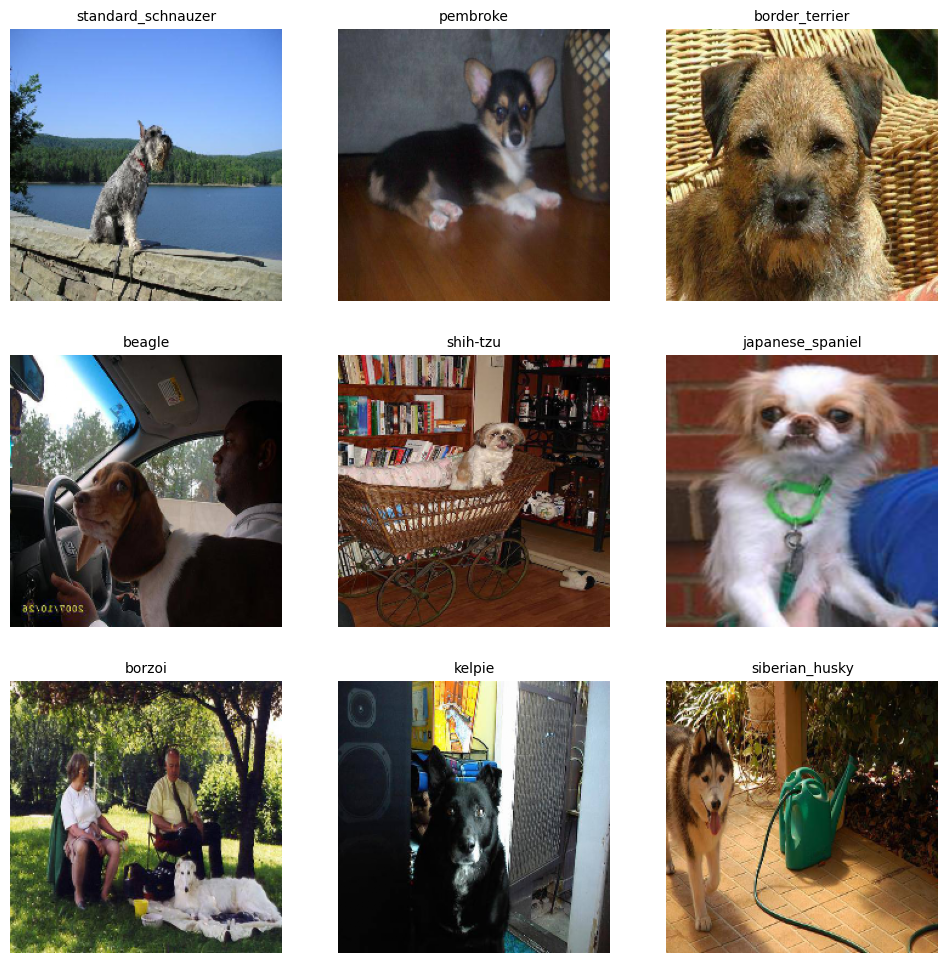

In [6]:
data_loaders.preview_data_sample(train_dataset, label_dict)

In [ ]:
torch.cuda.empty_cache()
model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
# Freeze all pretrained parameters to avoid using them in training
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the head (the last layer, aka the final classification layer) with our own randomized weights
# and output the appropriate number of classes for our problem.
# The last layer was trained for the particular classification problem that the original model was intended for
# It is never any good for you (unless you are doing an identical problem)
# Match the in features with those of the original last layer, then specify new ones for the out for your problem
# Note that different models may have different names for the classification layer (see "image_nets fine-tuning conversation.md")
model.fc = torch.nn.Linear(model.fc.in_features, len(label_dict.items())).to("cuda")

epochs = 20
# optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        # 32
        torch.utils.data.DataLoader(train_dataset, batch_size=128), 
        torch.utils.data.DataLoader(valid_dataset, batch_size=128),
        # TODO: figure out test dataset (no labels? Just pass none for label or don't pass at all?)
        torch.utils.data.DataLoader(valid_dataset, batch_size=128)
    ),
    model=model,
    loss_function=torch.nn.CrossEntropyLoss(),
    metric_function=learning.accuracy,
    optimizer=optimizer,
    scheduler=None,
    device="cuda"
    # device="cpu"
)

# TODOs
# Best way to normalize image sizes
# See how much unfreezing prior layers helps (aka fine tuning?)
learner.train_model(epochs=epochs)

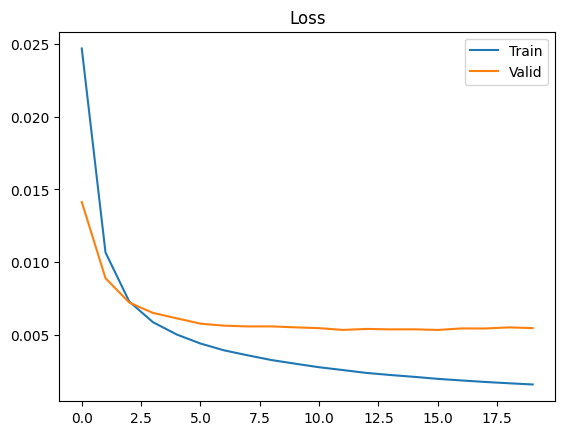

In [9]:
learner.plot_epoch_data()

In [76]:
reload(data_loaders)

<module 'data_loaders' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\data_loaders.py'>

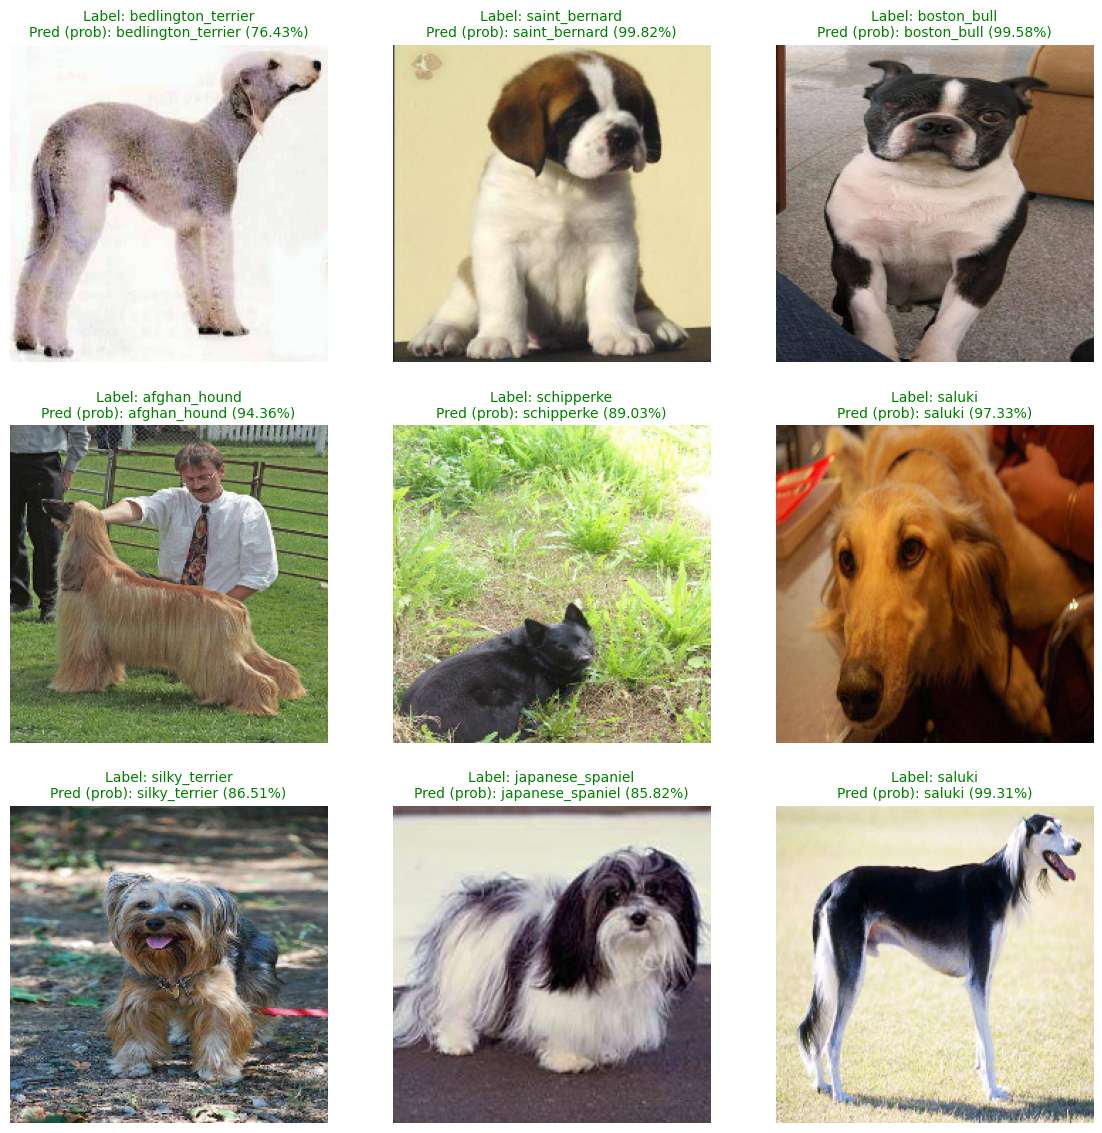

In [10]:
data_loaders.preview_tested_data_sample(valid_dataset, model, label_dict, "cuda")

In [ ]:
# TODO: add early stopping algo
# TODO: look up better pytorch notebooks for this dataset
# TODO: implement fit_one_cycle algo